# $\textit{In Silico}$ study of human upper arm arterial network

![](images/hand.png)

In [1]:
import os
from sys import argv
import numpy as np
import matplotlib.pyplot as plt
# path = "../"
# os.chdir(path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pylsewave.mesh import Vessel, VesselNetwork
from pylsewave.pdes import PDEm, PDEsWat, PDEsVisco
from pylsewave.bcs import BCs, BCsWat
from pylsewave.viz import PlotAndStoreSolution
from pylsewave.interpolate import CubicSpline
from pylsewave.nonlinearsolvers import Newton_system_conj_points
from pylsewave.fdm import BloodWaveMacCormack, BloodWaveLaxWendroff, BloodWaveMacCormackGodunov
from pylsewave.pwconsts import *
from pylsewave.pwutils import *

In [3]:
LANGUAGE="cy"

In [4]:
filename = "../data/Arterial_Network_ADAN56.txt"
data = np.loadtxt(filename, delimiter="&", dtype=np.str)
indexes = [7, 8, 9, 10, 11, 12, 13]  # create filter
data = data[indexes]

In [6]:
print(" \\\\\n".join([" & ".join(map(str, line)) for line in data]))

8  & Axilliary R  & 12.00  & 0.230  & 0.208  & 0.067  & 0.4  \\
9  & Brachial R  & 22.311  & 0.208  & 0.183  & 0.067  & 0.4  \\
10  & R. Radial  & 30.089  & 0.138  & 0.138  & 0.043  & 0.8  \\
11  & R. Ulnar\; I  & 2.976  & 0.141  & 0.141  & 0.046  & 0.8  \\
12  & R. Interosseous  & 1.627  & 0.096  & 0.096  & 0.028  & 1.6  \\
13  & Posterior interosseous R  & 23.056  & 0.068  & 0.068  & 0.028  & 1.6  \\
14  & R. Ulnar \;II  & 23.926  & 0.141  & 0.141  & 0.046  & 0.8 


### Simulation of upper extremity pulse wave propagation assuming a linear model for arterial walls

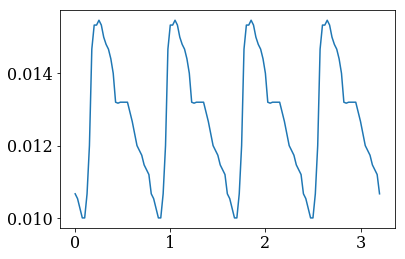

The min length to wave speed radio has been computed to Vessel: 'R. Interosseous ' 
7.624261299844918e-05
Solver set to dt=0.000076243
Wall time: 2min 50s
[-] Cleaning temporary files...
Archive name: ./results/Hand_model_Cython_10Nx_CFL05_Linear_junb_archive.npz


In [9]:
# Mynard
k = np.array([33.7e-03, 0.3, -0.9])

nu = CONSTANT_MU_BLOOD/CONSTANT_RHO_BLOOD

T_cycle = 0.8
tc = 4
T = T_cycle*tc

dt = 1e-4

p0 = 0.
# -------- SEGMENTS ------------ #
segments = []
for i in range(data.shape[0]):
    segments.append(Vessel(name=data[i, 1], L=float(data[i, 2]) * 10.,
                           R_proximal=float(data[i, 3]) * 10.,
                           R_distal=float(data[i, 4]) * 10.,
                           Wall_thickness=float(data[i, 5]) * 10., Id=i))
    # set k vector
    segments[i].set_k_vector(k=k)

# -------  INFLOW (IN VIVO) WAVE  ------- #
invivo_data_brachial_p = np.loadtxt("../data/brachial_p_zambanini_invivo.txt", delimiter=",")
time_measured = invivo_data_brachial_p[:, 0]
pressure_measured = invivo_data_brachial_p[:, 1]*0.00013332239 # convert to MPa
time_periodic, pressure_periodic = convert_data_periodic(time_measured, pressure_measured, tc, True)

p_inlet_bc = CubicSpline(time_periodic, pressure_periodic)

# -------  TERMINAL VESSELS  ------- #
terminal_vessels = {2: [11539., 46155., 4.909e-06], 5: [47813., 191252., 1.185e-06],
                    6: [11749., 46995., 4.821e-06]}

for i in terminal_vessels.keys():
    terminal_vessels[i][0] = terminal_vessels[i][0]*1e-010
    terminal_vessels[i][1] = terminal_vessels[i][1]*1e-010
    terminal_vessels[i][2] = terminal_vessels[i][2]*1e+010

# -------  BIFURCATIONS  ------- #
bif_vessels = [[1, 2, 3],
               [3, 4, 6]]

# -------  CONJUCTIONS  ------- #
conj_points = [[0, 1],
               [4, 5]]

for i in terminal_vessels.keys():
    # calculate wave speed with empirical formula
    c0_distal = compute_c(segments[i].r_dist, k, CONSTANT_RHO_BLOOD)
#     print c0_distal
    A0_distal = np.pi*((segments[i].r_dist)**2)
    # R1 should be the same with the input characteristic impedance
    Z1_distal = (CONSTANT_RHO_BLOOD * c0_distal) / A0_distal
#     Z1_distal = terminal_vessels[i][0]
    R1 = terminal_vessels[i][0]
    R2 = terminal_vessels[i][1]
    C_t = terminal_vessels[i][2]
#     print Z1_distal - R2
    # add RLC data in each terminal vessel
    segments[i].RLC = {"R_1": Z1_distal, "R_t": R2, "C_t": C_t}

# create the Arterial Network domain/mesh
# Reflecting BCs
Nx = None
vesssel_network = VesselNetwork(vessels=segments, dx=2., Nx=Nx)

# give a name for the output database file
# casename = "/results/Hand_model_Python_10Nx_CFL05_Linear"
casename = "/results/Hand_model_Cython_10Nx_CFL05_Linear_junb"

# check CFL and set dx accordingly
siz_ves = len(vesssel_network.vessels)
compare_l_c0 = []
for i in range(siz_ves):
    c_max = np.max(compute_c(vesssel_network.vessels[i].r0, k, CONSTANT_RHO_BLOOD))
    A = np.pi * (vesssel_network.vessels[i].r_prox * vesssel_network.vessels[i].r_prox)
    compare_l_c0.append(vesssel_network.vessels[i].length / c_max)

min_value = min(compare_l_c0)
index_min_value = np.argmin(compare_l_c0)
print("The min length to wave speed radio has been computed to Vessel: '%s' " % vesssel_network.vessels[
    index_min_value].name)

# Nx_i = 1
min_time = []
for i in range(siz_ves):
    Nx_i = 10 * np.floor((vesssel_network.vessels[i].length / compute_c(vesssel_network.vessels[i].r_prox, k, CONSTANT_RHO_BLOOD)) / (min_value))
    dx_i = vesssel_network.vessels[i].length / Nx_i
    vesssel_network.vessels[i].dx = dx_i
    min_time.append(dx_i / np.max(compute_c(vesssel_network.vessels[i].r0, k, CONSTANT_RHO_BLOOD)))

CFL = 0.5
dt = CFL * (min(min_time))
print(dt)

# callback function to store solution
number_of_frames = 200
skip = int(round(T / dt)) // number_of_frames
umin = 0.1
umax = 1.5
myCallback = PlotAndStoreSolution(casename=casename, umin=umin,
                                  umax=umax, skip_frame=skip,
                                  screen_movie=True, backend=None,
                                  filename='/results/tmpdata')


if LANGUAGE == "py":
    # Python classes linear
    # PDEs #
    myPDEs = PDEsWat(vesssel_network, rho=CONSTANT_RHO_BLOOD, mu=CONSTANT_MU_BLOOD)
    # BCS #
    myBCs = BCsWat(myPDEs, p_inlet_bc.eval_spline)
    U0_vessel = np.array([0], dtype=np.int)
    UL_vessel = np.array(list(terminal_vessels.keys()))
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = BloodWaveMacCormack(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    mySolver.solve(casename, myCallback)
    myCallback.close_file(casename)

elif LANGUAGE == "cy":
    from pylsewave.cynum import cPDEsWat, cBCsWat, cMacCormackSolver

    myPDEs = cPDEsWat(vesssel_network, rho=CONSTANT_RHO_BLOOD, mu=CONSTANT_MU_BLOOD)
    myBCs = cBCsWat(myPDEs, p_inlet_bc.eval_spline)

    U0_vessel = np.array([0],dtype=np.int)
    UL_vessel = np.array(list(terminal_vessels.keys()))
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = cMacCormackSolver(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    %time mySolver.solve(myCallback)
    myCallback.close_file(casename)

### Simulation of upper extremity pulse wave propagation assuming a visco-elastic model for arterial walls

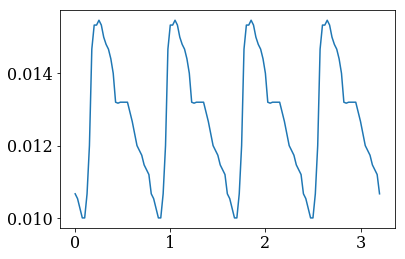

The min length to wave speed radio has been computed to Vessel: 'R. Interosseous ' 
7.624261299844918e-05
Solver set to dt=0.000076243
[==================================================] 100.00%The time increment dt was: 0.000076243
[-] Cleaning temporary files...
Archive name: ./results/Hand_model_Python_10Nx_CFL05_Visco_junb_archive.npz


In [15]:
# Mynard
k = np.array([33.7e-03, 0.3, -0.9])


nu = CONSTANT_MU_BLOOD/CONSTANT_RHO_BLOOD

T_cycle = 0.8
tc = 4
T = T_cycle*tc

dt = 1e-4

p0 = 0.
# -------- SEGMENTS ------------ #
segments = []
for i in range(data.shape[0]):
    segments.append(Vessel(name=data[i, 1], L=float(data[i, 2]) * 10.,
                           R_proximal=float(data[i, 3]) * 10.,
                           R_distal=float(data[i, 4]) * 10.,
                           Wall_thickness=float(data[i, 5]) * 10., Id=i))
    # set k vector
    segments[i].set_k_vector(k=k)

# -------  INFLOW (IN VIVO) WAVE  ------- #
invivo_data_brachial_p = np.loadtxt("../data/brachial_p_zambanini_invivo.txt", delimiter=",")
time_measured = invivo_data_brachial_p[:, 0]
pressure_measured = invivo_data_brachial_p[:, 1]*0.00013332239 # convert to MPa
time_periodic, pressure_periodic = convert_data_periodic(time_measured, pressure_measured, tc, True)

p_inlet_bc = CubicSpline(time_periodic, pressure_periodic)

# -------  TERMINAL VESSELS  ------- #
terminal_vessels = {2: [11539., 46155., 4.909e-06], 5: [47813., 191252., 1.185e-06],
                    6: [11749., 46995., 4.821e-06]}

for i in terminal_vessels.keys():
    terminal_vessels[i][0] = terminal_vessels[i][0]*1e-010
    terminal_vessels[i][1] = terminal_vessels[i][1]*1e-010
    terminal_vessels[i][2] = terminal_vessels[i][2]*1e+010

# -------  BIFURCATIONS  ------- #
bif_vessels = [[1, 2, 3],
               [3, 4, 6]]

# -------  CONJUCTIONS  ------- #
conj_points = [[0, 1],
               [4, 5]]

for i in terminal_vessels.keys():
    # calculate wave speed with empirical formula
    c0_distal = compute_c(segments[i].r_dist, k, )
#     print c0_distal
    A0_distal = np.pi*((segments[i].r_dist)**2)
    # R1 should be the same with the input characteristic impedance
    Z1_distal = (rho * c0_distal) / A0_distal
#     Z1_distal = terminal_vessels[i][0]
    R1 = terminal_vessels[i][0]
    R2 = terminal_vessels[i][1]
    C_t = terminal_vessels[i][2]
#     print Z1_distal - R2
    # add RLC data in each terminal vessel
    segments[i].RLC = {"R_1": Z1_distal, "R_t": R2, "C_t": C_t}

# create the Arterial Network domain/mesh
# Reflecting BCs
Nx = None
vesssel_network = VesselNetwork(vessels=segments, dx=2., Nx=Nx)

# give a name for the output database file
# casename = "/results/Hand_model_Python_10Nx_CFL05_Linear"
casename = "/results/Hand_model_Python_10Nx_CFL05_Visco_junb"

# check CFL and set dx accordingly
siz_ves = len(vesssel_network.vessels)
compare_l_c0 = []
for i in range(siz_ves):
    c_max = np.max(compute_c(vesssel_network.vessels[i].r0, k))
    A = np.pi * (vesssel_network.vessels[i].r_prox * vesssel_network.vessels[i].r_prox)
    compare_l_c0.append(vesssel_network.vessels[i].length / c_max)

min_value = min(compare_l_c0)
index_min_value = np.argmin(compare_l_c0)
print("The min length to wave speed radio has been computed to Vessel: '%s' " % vesssel_network.vessels[
    index_min_value].name)

# Nx_i = 1
min_time = []
for i in range(siz_ves):
    Nx_i = 10 * np.floor((vesssel_network.vessels[i].length / compute_c(vesssel_network.vessels[i].r_prox, k)) / (min_value))
    dx_i = vesssel_network.vessels[i].length / Nx_i
    vesssel_network.vessels[i].dx = dx_i
    min_time.append(dx_i / np.max(compute_c(vesssel_network.vessels[i].r0, k)))

CFL = 0.5
dt = CFL * (min(min_time))
print(dt)

# callback function to store solution
number_of_frames = 200
skip = int(round(T / dt)) / number_of_frames
umin = 0.1
umax = 1.5
myCallback = PlotAndStoreSolution(casename=casename, umin=umin,
                                  umax=umax, skip_frame=skip,
                                  screen_movie=True, backend=None,
                                  filename='/results/tmpdata')


#Add viscosity param
for i in range(siz_ves):
    vesssel_network.vessels[i].phi = CONST_PHI

if LANGUAGE == "py":
    class BCsViscoHand(BCsWat):
        def U_L(self, u, t, dx, dt, vessel_index, out):
            """
            Class method to compute the outlet BCs
            """
            _A, _q = u
            a_out = None
            q_out = None
            theta = dt / dx
            dt2 = dt / 2.
            p_out = self._pdes.pressure_i(_A, _q, -1, vessel_index)
            p0 = self._pdes.pressure_i(_A, _q, -1, vessel_index)

            q_m1 = out[1, -2]

            # a_out = A_n - theta * (q_out - u_m1[1]) # alternative
            k = 0
            R1 = self.vessels[vessel_index].RLC["R_1"]
            Rt = self.vessels[vessel_index].RLC["R_t"]
            Ct = self.vessels[vessel_index].RLC["C_t"]

            x = (dt / (R1 * Rt * Ct))
    #        A__ = _A.copy()
            while k < 1000:
                p_old = p0
                q_out = (x * p_out - x * (R1 + Rt) * _q[-1] +
                         (p0 - p_out) / R1 + _q[-1])

                a_out = _A[-1] - theta * (q_out - q_m1)
                _A[-1] = a_out
                p0 = self._pdes.pressure_i(_A, _q, index=-1, vessel_index=vessel_index)

                if abs(p_old - p0) < 1e-7:
                    break
                k += 1
    #        print k

            out[0, -1] = a_out
            out[1, -1] = q_out
    # Python classes visco
    # PDEs #
    myPDEs = PDEsVisco(vesssel_network, rho=CONSTANT_rho, mu=CONSTANT_mu)
    # BCS #
    myBCs = BCsViscoHand(myPDEs, p_inlet_bc.eval_spline)
    U0_vessel = np.array([0],dtype=np.int)
    UL_vessel = np.array(terminal_vessels.keys())
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = BloodWaveMacCormackGodunov(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    mySolver.solve(casename, myCallback)
    myCallback.close_file(casename)

elif LANGUAGE == "cy":
    from pylsewave.cynum import cBCsWat, cMacCormackSolver, cPDEsWatVisco, cMacCormackGodunovSplitSolver

    myPDEs = cPDEsWatVisco(vesssel_network, rho=CONSTANT_rho, mu=CONSTANT_mu)
    myBCs = cBCsWat(myPDEs, p_inlet_bc.eval_spline)

    U0_vessel = np.array([0],dtype=np.int)
    UL_vessel = np.array(terminal_vessels.keys())
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = cMacCormackGodunovSplitSolver(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    %time mySolver.solve(casename, myCallback)
    myCallback.close_file(casename)

## Molel disease in upper extremity

In [17]:
# class inheritted by the ScaledVessel to overwrite the computation of R0 
class DiseasedVessel(Vessel):
    def __init__(self, x_p, t, d_disease, type_disease,
                 *args, **kwargs):
        super(DiseasedVessel, self).__init__(*args, **kwargs)
        self._x_p = x_p
        self._sharpness = t
        self._d_disease = d_disease
        self._type_disease = type_disease

    @property
    def dx(self):
        return self._dx
        
    @dx.setter
    def dx(self, dx):
        # here we reduce dx if the length of the segment is less than dx
        if (int(round(self.length/dx)) + 1) == 1:
            self._x = np.array([0., self.length])
        # self._dx = dx
        else:
            self._x = np.linspace(0., self.length, int(round(self.length/dx)) + 1)
        # make sure that dx is correct!
        self._dx = self._x[1] - self._x[0]
        # print self._dx
        # self._R0 = self.r_prox * np.exp(np.log(self.r_dist / self.r_prox) * (self.x / self.length))
        self._R0 = self.calculate_R0(self._x)
        if self._k is not None:
            self._f_r0 = self.f(self._R0, self._k)
            self._df_dr0 = self.dfdr(self._R0, self._k)
            self._df_dx = np.gradient(self._R0, self._dx)
            self._f_r0_ph  = self.f(self._R0, self._k)
            self._df_dr0_ph = self.dfdr(self._R0, self._k)
            self._df_dx_ph = np.gradient(self._R0, self._dx)
            self._f_r0_mh  = self.f(self._R0, self._k)
            self._df_dr0_mh = self.dfdr(self._R0, self._k)
            self._df_dx_mh = np.gradient(self._R0, self._dx)

    def calculate_R0(self, x):
        y = self.Gen_Hicks_bump(x)
        axis = self.r_prox*2 + 2*self.w_th
        if self._type_disease == "stenosis":
#             print "yes"
            y_mirror = axis - y
            Diameter = y_mirror - y
        elif self._type_disease == "aneurysm":
            y_1 = y + 2*self.r_prox
            y_2 = (axis - y) - 2*self.r_prox
            Diameter = y_1 - y_2
#         print("Diameter", Diameter)
        return Diameter / 2.

    def interpolate_R0(self, value):


        return np.zeros(self.r0.shape[0], np.float)

    def Gen_Hicks_bump(self, x):
        A = (self.w_th + (self.r_prox - (self.r_prox - (self.r_prox*self._d_disease)/100.)))
        y = (self.w_th + (A - self.w_th) * ((np.sin(np.pi*((x/self._L)**(-np.log(2)/np.log(self._x_p)))))**self._sharpness))
    
        return(y)
    

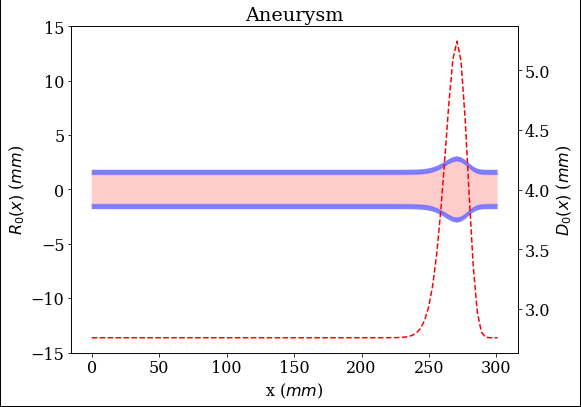

In [18]:
PLOT = True
vessel_index = 2
vesselAAA = DiseasedVessel(x_p=0.9, t=10., d_disease=90., type_disease="aneurysm", name=data[vessel_index, 1],
                           L=float(data[vessel_index, 2]) * 10.,
                           R_proximal=float(data[vessel_index, 3]) * 10.,
                           R_distal=float(data[vessel_index, 4]) * 10.,
                           Wall_thickness=float(data[vessel_index, 5]) * 10., Id=vessel_index)
vesselAAA.set_k_vector(np.array([33.7e-03, 0.3, -0.9]))
dx_i = vesselAAA.length / 100.0
vesselAAA.dx = dx_i
# print(vesselAAA.r0)
if PLOT is True:
    figHicks_ = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k',
                           linewidth= 2.0, frameon=True)
    ax = figHicks_.add_subplot(1, 1, 1)
    ax_twin = ax.twinx()

    ax.plot(vesselAAA.x, vesselAAA.r0, "b", alpha=0.2)
    ax.plot(vesselAAA.x, -vesselAAA.r0, "b", alpha=0.2)
    ax.fill_between(vesselAAA.x, vesselAAA.r0, -vesselAAA.r0, facecolor='red', alpha=0.2)
    ax.fill_between(vesselAAA.x, vesselAAA.r0, vesselAAA.r0 + vesselAAA.w_th, facecolor='blue', alpha=0.5)
    ax.fill_between(vesselAAA.x, -vesselAAA.r0, -vesselAAA.r0 - vesselAAA.w_th, facecolor='blue', alpha=0.5)

    ax_twin.plot(vesselAAA.x, 2*vesselAAA.r0, "r--", label="Diameter ($D_0(x)$)")

    ax.set_ylim([-15, 15])
    ax.set_ylabel(r"$R_0(x)$ ($mm$)")
    ax.set_xlabel("x ($mm$)")

    ax_twin.set_ylabel("$D_0(x)$ ($mm$)")
    plt.title("Aneurysm")
    plt.show()

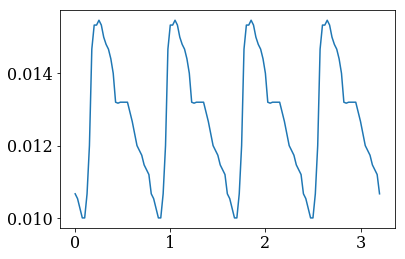

The min length to wave speed radio has been computed to Vessel: 'R. Interosseous ' 
7.624261299844918e-05
Solver set to dt=0.000076243
Wall time: 55.6 s
[-] Cleaning temporary files...
Archive name: ./results/Hand_model_Cython_10Nx_CFL05_Visco_junb_UlnarAneurysm_archive.npz


In [20]:
# Mynard
k = np.array([33.7e-03, 0.3, -0.9])

mu = 4.0e-09
rho = 1.04e-9
nu = mu/rho

T_cycle = 0.8
tc = 4
T = T_cycle*tc

dt = 1e-4

p0 = 0.
# -------- SEGMENTS ------------ #
vessel_index = 2
segments = []
for i in range(data.shape[0]):
    if i != vessel_index:
        segments.append(Vessel(name=data[i, 1], L=float(data[i, 2]) * 10.,
                               R_proximal=float(data[i, 3]) * 10.,
                               R_distal=float(data[i, 4]) * 10.,
                               Wall_thickness=float(data[i, 5]) * 10., Id=i))
    else:
        segments.append(DiseasedVessel(x_p=0.9, t=10., d_disease=90., type_disease="aneurysm", name=data[i, 1],
                                       L=float(data[i, 2]) * 10.,
                                       R_proximal=float(data[i, 3]) * 10.,
                                       R_distal=float(data[i, 4]) * 10.,
                                       Wall_thickness=float(data[i, 5]) * 10., Id=i))
    
    # set k vector
    segments[i].set_k_vector(k=k)

# -------  INFLOW (IN VIVO) WAVE  ------- #
invivo_data_brachial_p = np.loadtxt("../data/brachial_p_zambanini_invivo.txt", delimiter=",")
time_measured = invivo_data_brachial_p[:, 0]
pressure_measured = invivo_data_brachial_p[:, 1]*0.00013332239 # convert to MPa
time_periodic, pressure_periodic = convert_data_periodic(time_measured, pressure_measured, tc, True)

p_inlet_bc = CubicSpline(time_periodic, pressure_periodic)

# -------  TERMINAL VESSELS  ------- #
terminal_vessels = {2: [11539., 46155., 4.909e-06], 5: [47813., 191252., 1.185e-06],
                    6: [11749., 46995., 4.821e-06]}

for i in terminal_vessels.keys():
    terminal_vessels[i][0] = terminal_vessels[i][0]*1e-010
    terminal_vessels[i][1] = terminal_vessels[i][1]*1e-010
    terminal_vessels[i][2] = terminal_vessels[i][2]*1e+010

# -------  BIFURCATIONS  ------- #
bif_vessels = [[1, 2, 3],
               [3, 4, 6]]

# -------  CONJUCTIONS  ------- #
conj_points = [[0, 1],
               [4, 5]]

for i in terminal_vessels.keys():
    # calculate wave speed with empirical formula
    c0_distal = compute_c(segments[i].r_dist, k)
#     print c0_distal
    A0_distal = np.pi*((segments[i].r_dist)**2)
    # R1 should be the same with the input characteristic impedance
    Z1_distal = (rho * c0_distal) / A0_distal
#     Z1_distal = terminal_vessels[i][0]
    R1 = terminal_vessels[i][0]
    R2 = terminal_vessels[i][1]
    C_t = terminal_vessels[i][2]
#     print Z1_distal - R2
    # add RLC data in each terminal vessel
    segments[i].RLC = {"R_1": Z1_distal, "R_t": R2, "C_t": C_t}

# create the Arterial Network domain/mesh
# Reflecting BCs
Nx = None
vesssel_network = VesselNetwork(vessels=segments, dx=2., Nx=Nx)

# give a name for the output database file
# casename = "/results/Hand_model_Python_10Nx_CFL05_Linear"
casename = "/results/Hand_model_Cython_10Nx_CFL05_Visco_junb_UlnarAneurysm"

# check CFL and set dx accordingly
siz_ves = len(vesssel_network.vessels)
compare_l_c0 = []
for i in range(siz_ves):
    c_max = np.max(compute_c(vesssel_network.vessels[i].r0, k))
    A = np.pi * (vesssel_network.vessels[i].r_prox * vesssel_network.vessels[i].r_prox)
    compare_l_c0.append(vesssel_network.vessels[i].length / c_max)

min_value = min(compare_l_c0)
index_min_value = np.argmin(compare_l_c0)
print("The min length to wave speed radio has been computed to Vessel: '%s' " % vesssel_network.vessels[
    index_min_value].name)

# Nx_i = 1
min_time = []
for i in range(siz_ves):
    Nx_i = 10 * np.floor((vesssel_network.vessels[i].length / compute_c(vesssel_network.vessels[i].r_prox, k)) / (min_value))
    dx_i = vesssel_network.vessels[i].length / Nx_i
    vesssel_network.vessels[i].dx = dx_i
    min_time.append(dx_i / np.max(compute_c(vesssel_network.vessels[i].r0, k)))

    
CFL = 0.5
dt = CFL * (min(min_time))
print(dt)

# callback function to store solution
number_of_frames = 200
skip = int(round(T / dt)) / number_of_frames
umin = 0.1
umax = 1.5
myCallback = PlotAndStoreSolution(casename=casename, umin=umin,
                                  umax=umax, skip_frame=skip,
                                  screen_movie=True, backend=None,
                                  filename='/results/tmpdata')


#Add viscosity param
for i in range(siz_ves):
    vesssel_network.vessels[i].phi = CONST_PHI

if LANGUAGE == "py":
    class BCsViscoHand(BCsWat):
        def U_L(self, u, t, dx, dt, vessel_index, out):
            """
            Class method to compute the outlet BCs
            """
            _A, _q = u
            a_out = None
            q_out = None
            theta = dt / dx
            dt2 = dt / 2.
            p_out = self._pdes.pressure_i(_A, _q, -1, vessel_index)
            p0 = self._pdes.pressure_i(_A, _q, -1, vessel_index)

            q_m1 = out[1, -2]

            # a_out = A_n - theta * (q_out - u_m1[1]) # alternative
            k = 0
            R1 = self.vessels[vessel_index].RLC["R_1"]
            Rt = self.vessels[vessel_index].RLC["R_t"]
            Ct = self.vessels[vessel_index].RLC["C_t"]

            x = (dt / (R1 * Rt * Ct))
    #        A__ = _A.copy()
            while k < 1000:
                p_old = p0
                q_out = (x * p_out - x * (R1 + Rt) * _q[-1] +
                         (p0 - p_out) / R1 + _q[-1])

                a_out = _A[-1] - theta * (q_out - q_m1)
                _A[-1] = a_out
                p0 = self._pdes.pressure_i(_A, _q, index=-1, vessel_index=vessel_index)

                if abs(p_old - p0) < 1e-7:
                    break
                k += 1
    #        print k

            out[0, -1] = a_out
            out[1, -1] = q_out
    # Python classes visco
    # PDEs #
    myPDEs = PDEsVisco(vesssel_network, rho=CONSTANT_rho, mu=CONSTANT_mu)
    # BCS #
    myBCs = BCsViscoHand(myPDEs, p_inlet_bc.eval_spline)
    U0_vessel = np.array([0],dtype=np.int)
    UL_vessel = np.array(terminal_vessels.keys())
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = BloodWaveMacCormackGodunov(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    mySolver.solve(casename, myCallback)
    myCallback.close_file(casename)

elif LANGUAGE == "cy":
    from pylsewave.cynum import cBCsWat, cMacCormackSolver, cPDEsWatVisco, cMacCormackGodunovSplitSolver

    myPDEs = cPDEsWatVisco(vesssel_network, rho=CONSTANT_rho, mu=CONSTANT_mu)
    myBCs = cBCsWat(myPDEs, p_inlet_bc.eval_spline)

    U0_vessel = np.array([0],dtype=np.int)
    UL_vessel = np.array(terminal_vessels.keys())
    UBif_vessel = np.array(bif_vessels)
    UConj_vessel = np.array(conj_points)

    mySolver = cMacCormackGodunovSplitSolver(myBCs)
    mySolver.set_T(dt=dt, T=T, no_cycles=tc)
    mySolver.set_BC(U0_vessel, UL_vessel, UBif_vessel, UConj_vessel)
    %time mySolver.solve(casename, myCallback)
    myCallback.close_file(casename)

### Post-processing

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pylsewave.postprocessing import ExtractUVectors

In [23]:
myodbf = ExtractUVectors("./results/Hand_model_Cython_10Nx_CFL05_Linear_junb_archive.npz")
myodbf_v = ExtractUVectors("./results/Hand_model_Cython_10Nx_CFL05_Visco_junb_archive.npz")
myodbf_vA = ExtractUVectors("./results/Hand_model_Cython_10Nx_CFL05_Visco_junb_UlnarAneurysm_archive.npz")
# sampling frequency
fr = 1 # kHz
sampling_period = 0.001
no_points = 1.0 / 0.001

vessels_plot = {i: data[i][1] for i in range(len(data))}

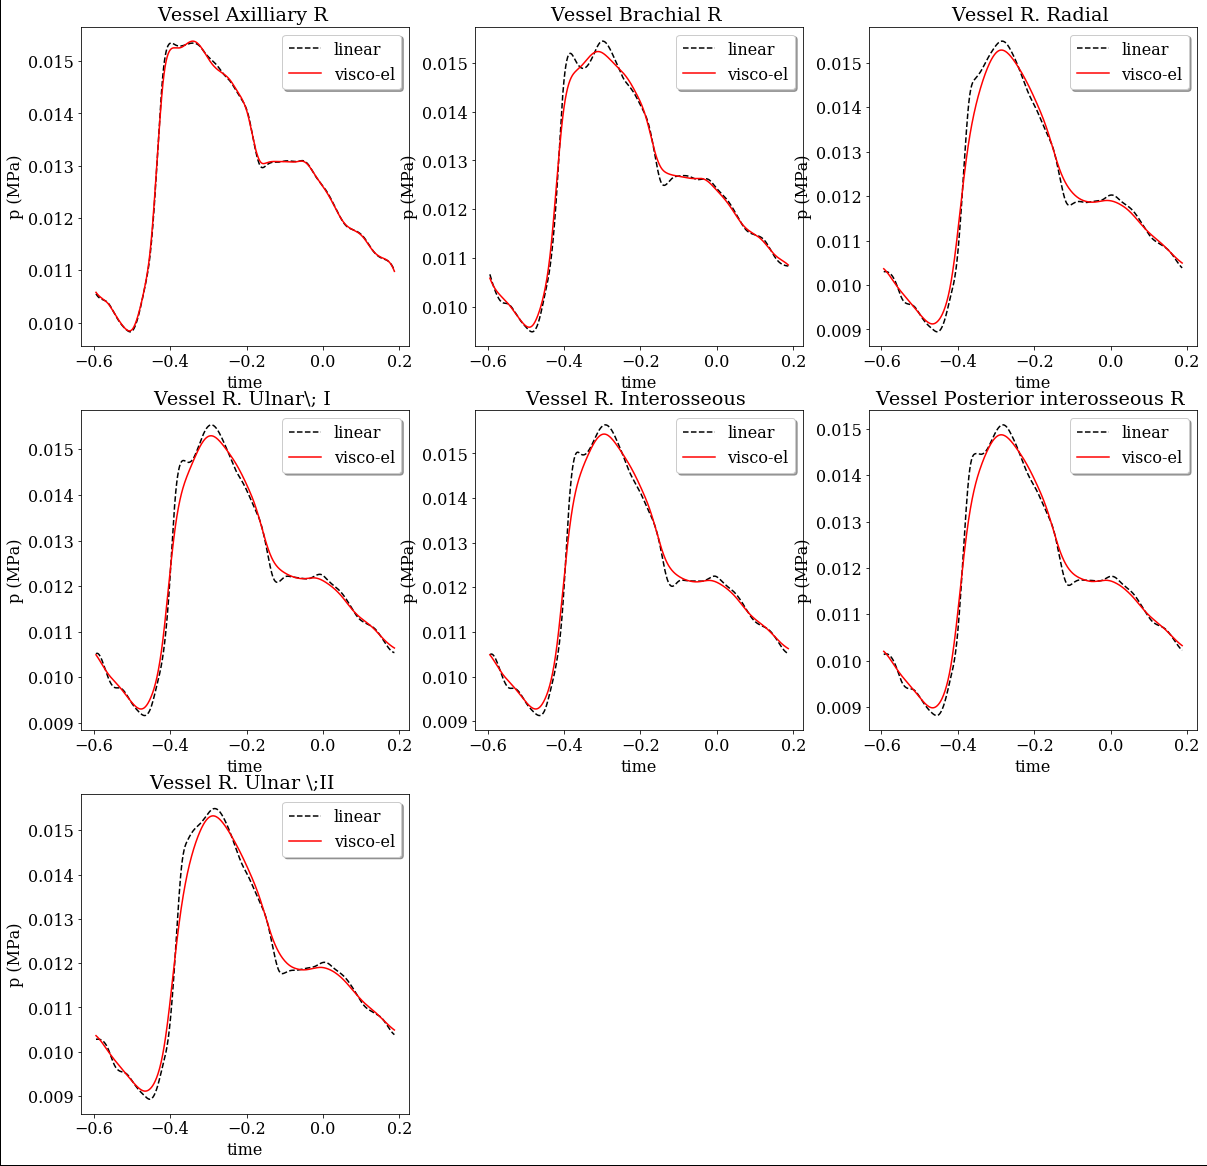

In [24]:
# pressure at different vessels
figbra = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                    linewidth= 2.0, frameon=True)

ax_i = []
for i in (vessels_plot.keys()):
    ax_i.append(figbra.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    p_plot = ax_i[i].plot(T_i[400, :] - 3.0, p_b[400, :], "k--", label="linear")
    p_plot = ax_i[i].plot(T_i[400, :] - 3.0, p_v[400, :], "r-", label="visco-el")
    ax_i[i].set_xlabel("time")
    ax_i[i].set_ylabel("p (MPa)")
    ax_i[i].set_title("Vessel %s" % vessels_plot[i])
    ax_i[i].legend(loc='best', ncol=1,
                   fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()

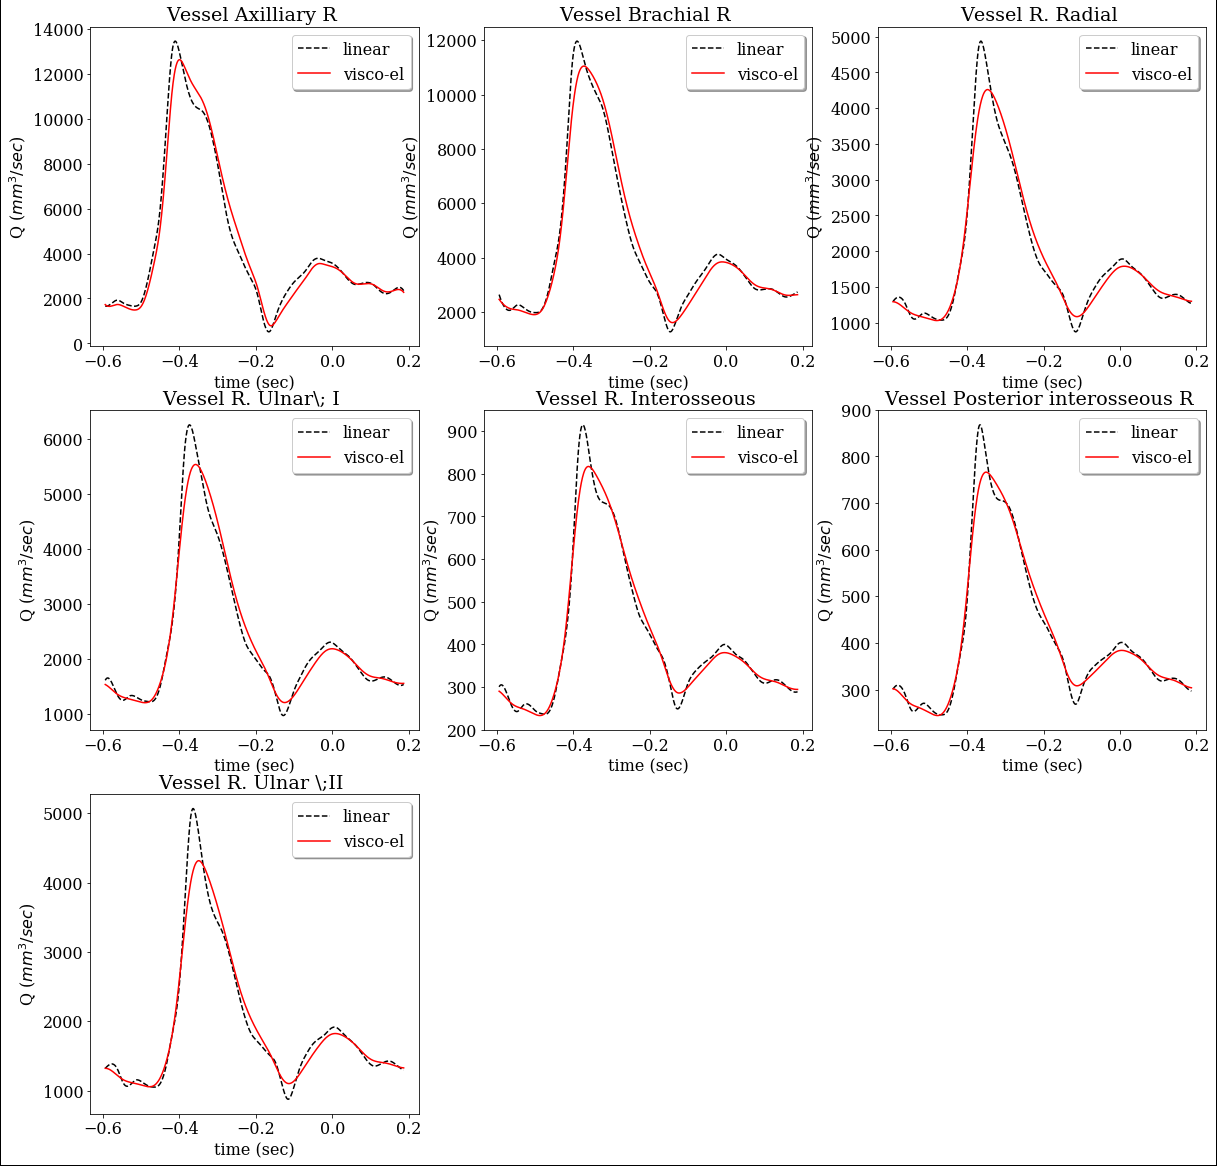

In [25]:
# flow at different vessels
figfw = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                   linewidth= 2.0, frameon=True)

ax_fw = []
for i in (vessels_plot.keys()):
    ax_fw.append(figfw.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    p_plot = ax_fw[i].plot(T_i[400, :]-3.0, q_b[400, :], "k--", label="linear")
    p_plot = ax_fw[i].plot(T_i[400, :]-3.0, q_v[400, :], "r-", label="visco-el")
    ax_fw[i].set_xlabel("time (sec)")
    ax_fw[i].set_ylabel("Q ($mm^3/sec$)")
    ax_fw[i].set_title("Vessel %s" % vessels_plot[i])
    ax_fw[i].legend(loc='best', ncol=1,
                    fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()

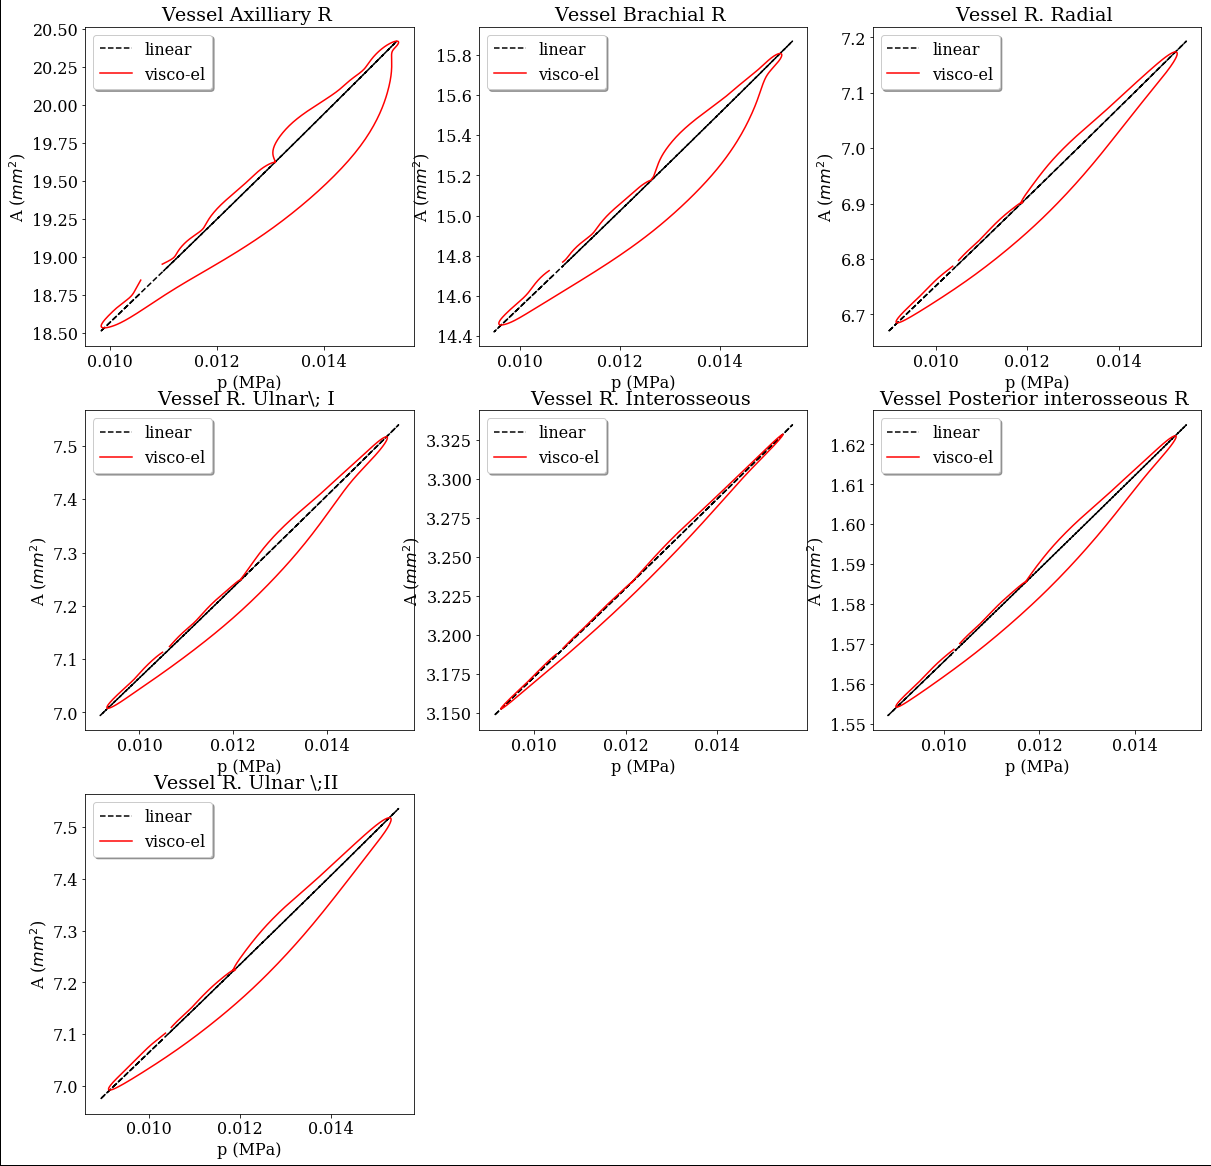

In [26]:
# pressure-area at different vessels
figpa = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                   linewidth= 2.0, frameon=True)

ax_pa = []
for i in (vessels_plot.keys()):
    ax_pa.append(figpa.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    p_plot = ax_pa[i].plot(p_b[400, :], A_b[400, :], "k--", label="linear")
    p_plot = ax_pa[i].plot(p_v[400, :], A_v[400, :], "r-", label="visco-el")
    ax_pa[i].set_xlabel("p (MPa)")
    ax_pa[i].set_ylabel("A ($mm^2$)")
    ax_pa[i].set_title("Vessel %s" % vessels_plot[i])
    ax_pa[i].legend(loc='best', ncol=1,
                    fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()

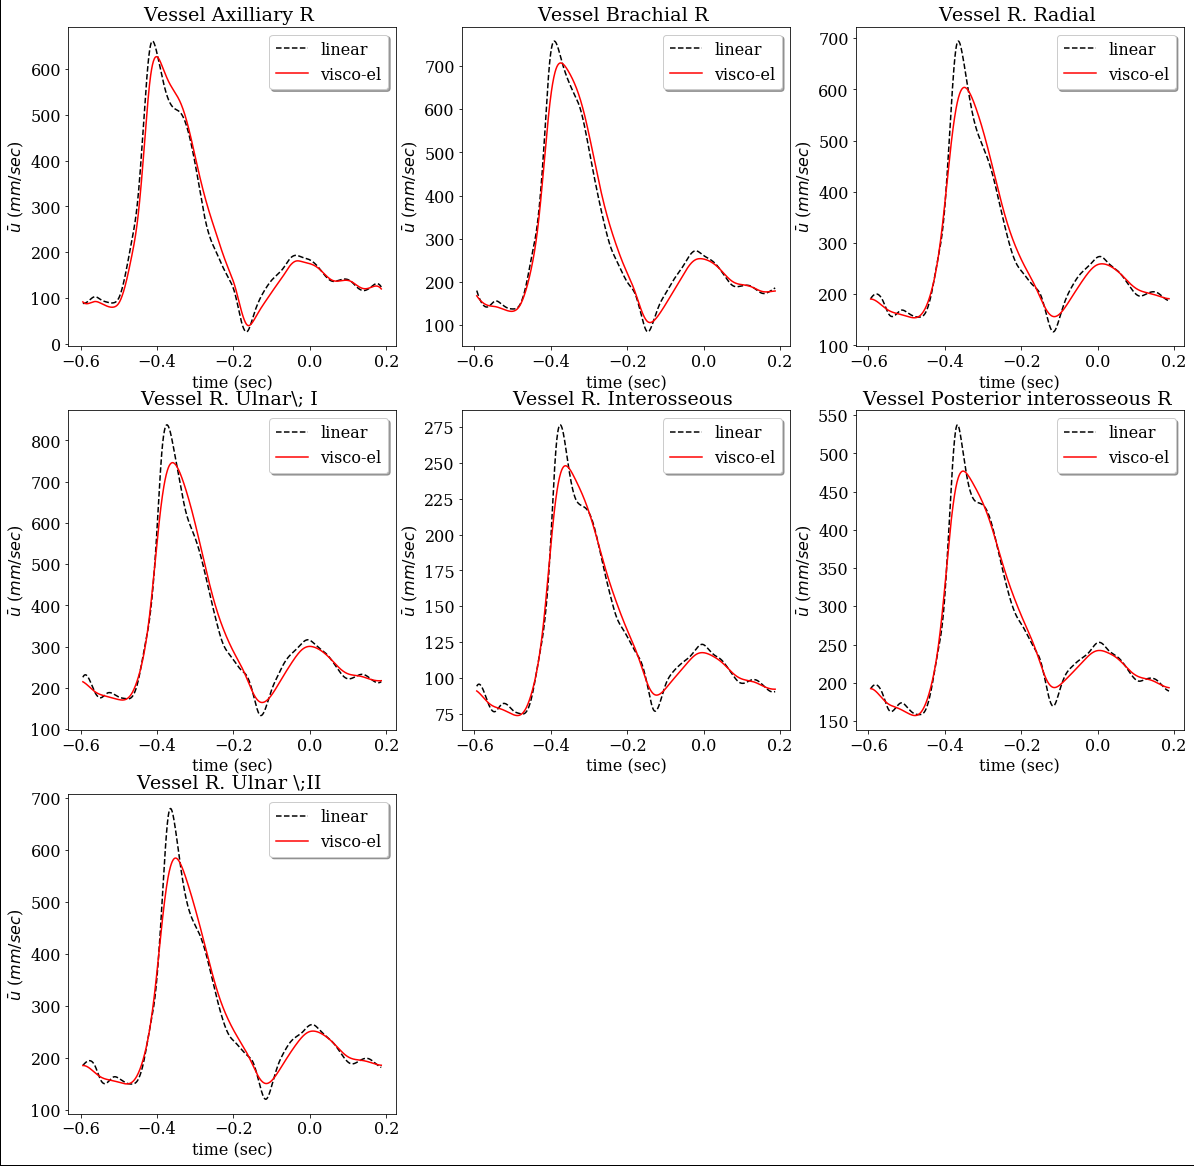

In [27]:
# velocity at different vessels
figv = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                   linewidth= 2.0, frameon=True)

ax_v = []
for i in (vessels_plot.keys()):
    ax_v.append(figv.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    p_plot = ax_v[i].plot(T_i[400, :]-3.0, u_b[400, :], "k--", label="linear")
    p_plot = ax_v[i].plot(T_i[400, :]-3.0, u_v[400, :], "r-", label="visco-el")
    ax_v[i].set_xlabel("time (sec)")
    ax_v[i].set_ylabel(r"$\bar{u}$ ($mm/sec$)")
    ax_v[i].set_title("Vessel %s" % vessels_plot[i])
    ax_v[i].legend(loc='best', ncol=1,
                    fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()

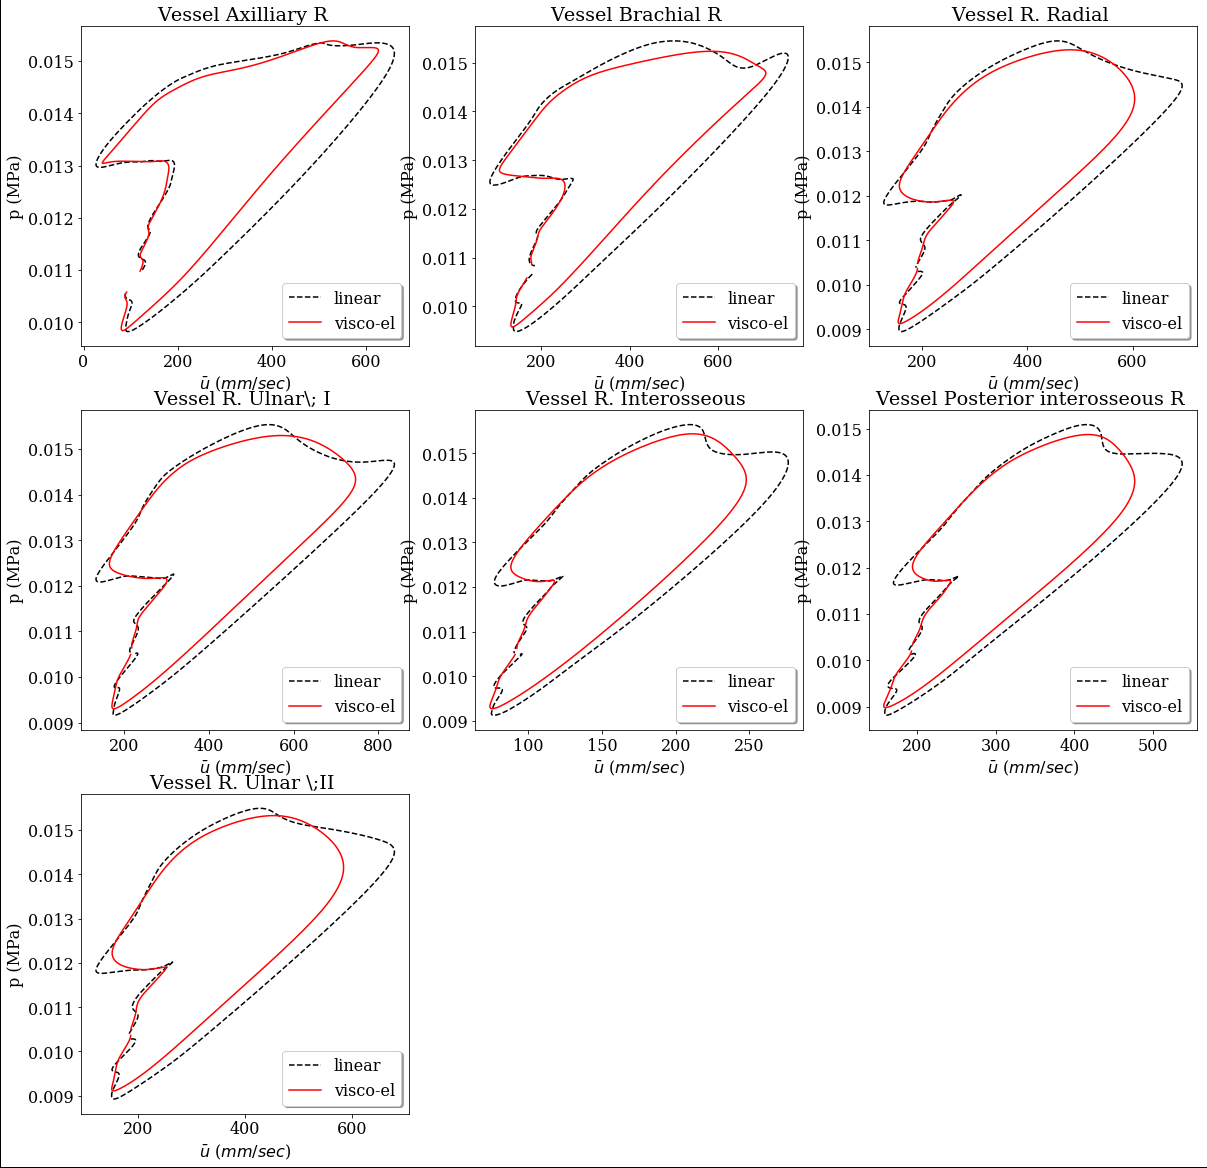

In [28]:
# pu loop at different vessels
figpu = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                   linewidth= 2.0, frameon=True)

ax_pu = []
for i in (vessels_plot.keys()):
    ax_pu.append(figpu.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    p_plot = ax_pu[i].plot(u_b[400, :], p_b[400, :], "k--", label="linear")
    p_plot = ax_pu[i].plot(u_v[400, :], p_v[400, :], "r-", label="visco-el")
    ax_pu[i].set_ylabel("p (MPa)")
    ax_pu[i].set_xlabel(r"$\bar{u}$ ($mm/sec$)")
    ax_pu[i].set_title("Vessel %s" % vessels_plot[i])
    ax_pu[i].legend(loc='best', ncol=1,
                    fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()

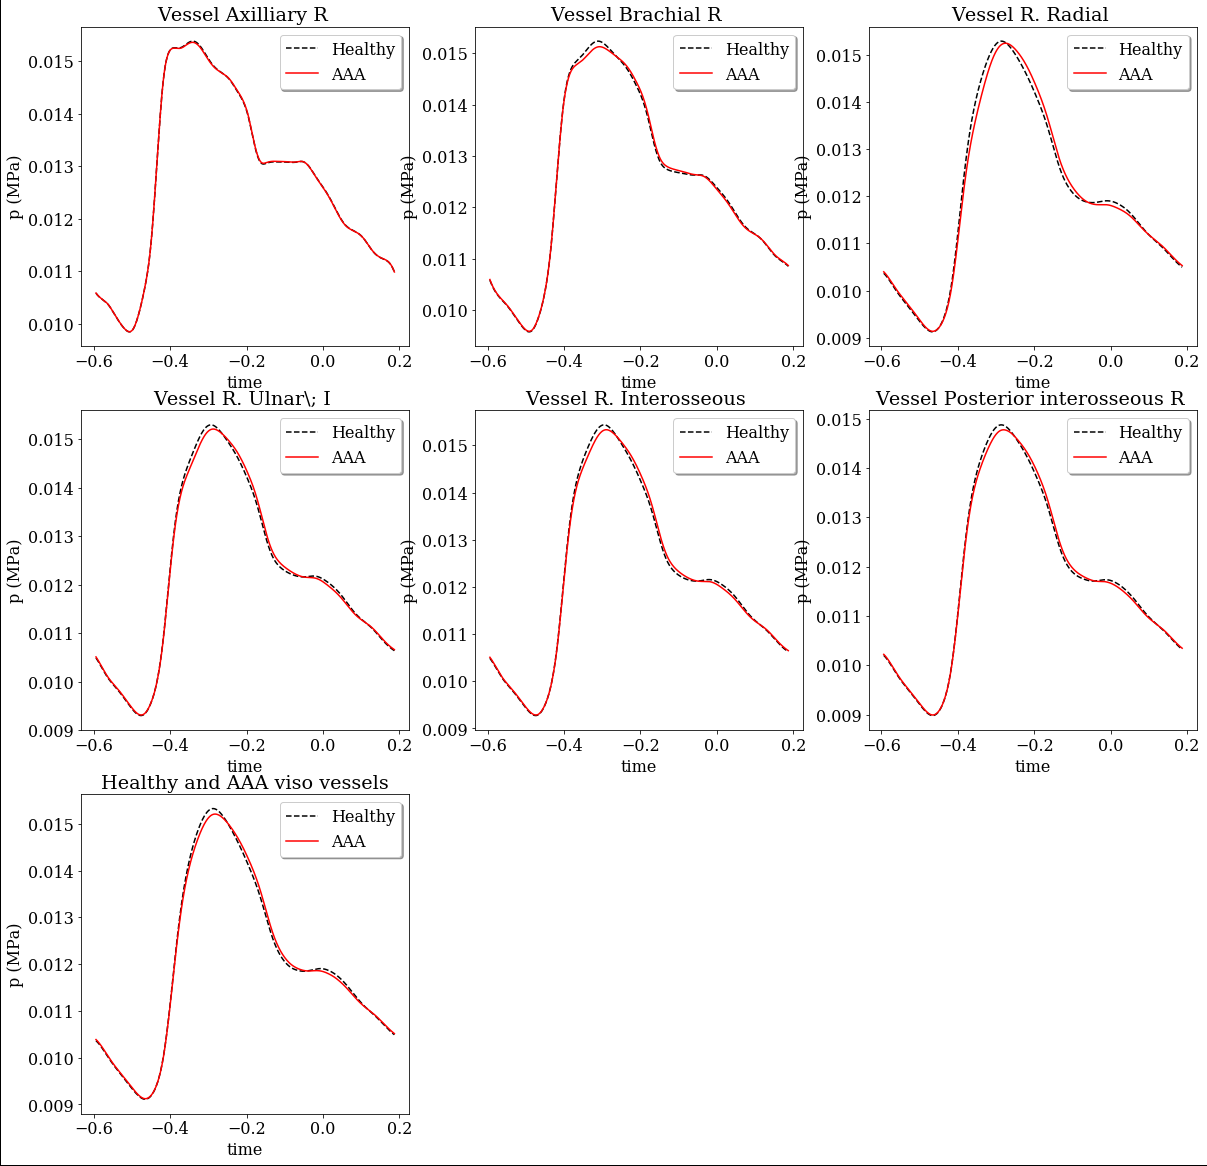

In [29]:
# pressure at different vessels AAA
figbra_AAA = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                        linewidth= 2.0, frameon=True)

ax_i_aaa = []
for i in (vessels_plot.keys()):
    ax_i_aaa.append(figbra_AAA.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_vA.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf_v.meshgrid_T
    X_i = myodbf_v.meshgrid_X
    p_plot = ax_i_aaa[i].plot(T_i[400, :] - 3.0, p_b[400, :], "k--", label="Healthy")
    p_plot = ax_i_aaa[i].plot(T_i[400, :] - 3.0, p_v[400, :], "r-", label="AAA")
    ax_i_aaa[i].set_xlabel("time")
    ax_i_aaa[i].set_ylabel("p (MPa)")
    ax_i_aaa[i].set_title("Vessel %s" % vessels_plot[i])
    ax_i_aaa[i].legend(loc='best', ncol=1,
                      fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.title("Healthy and AAA viso vessels")
plt.show()

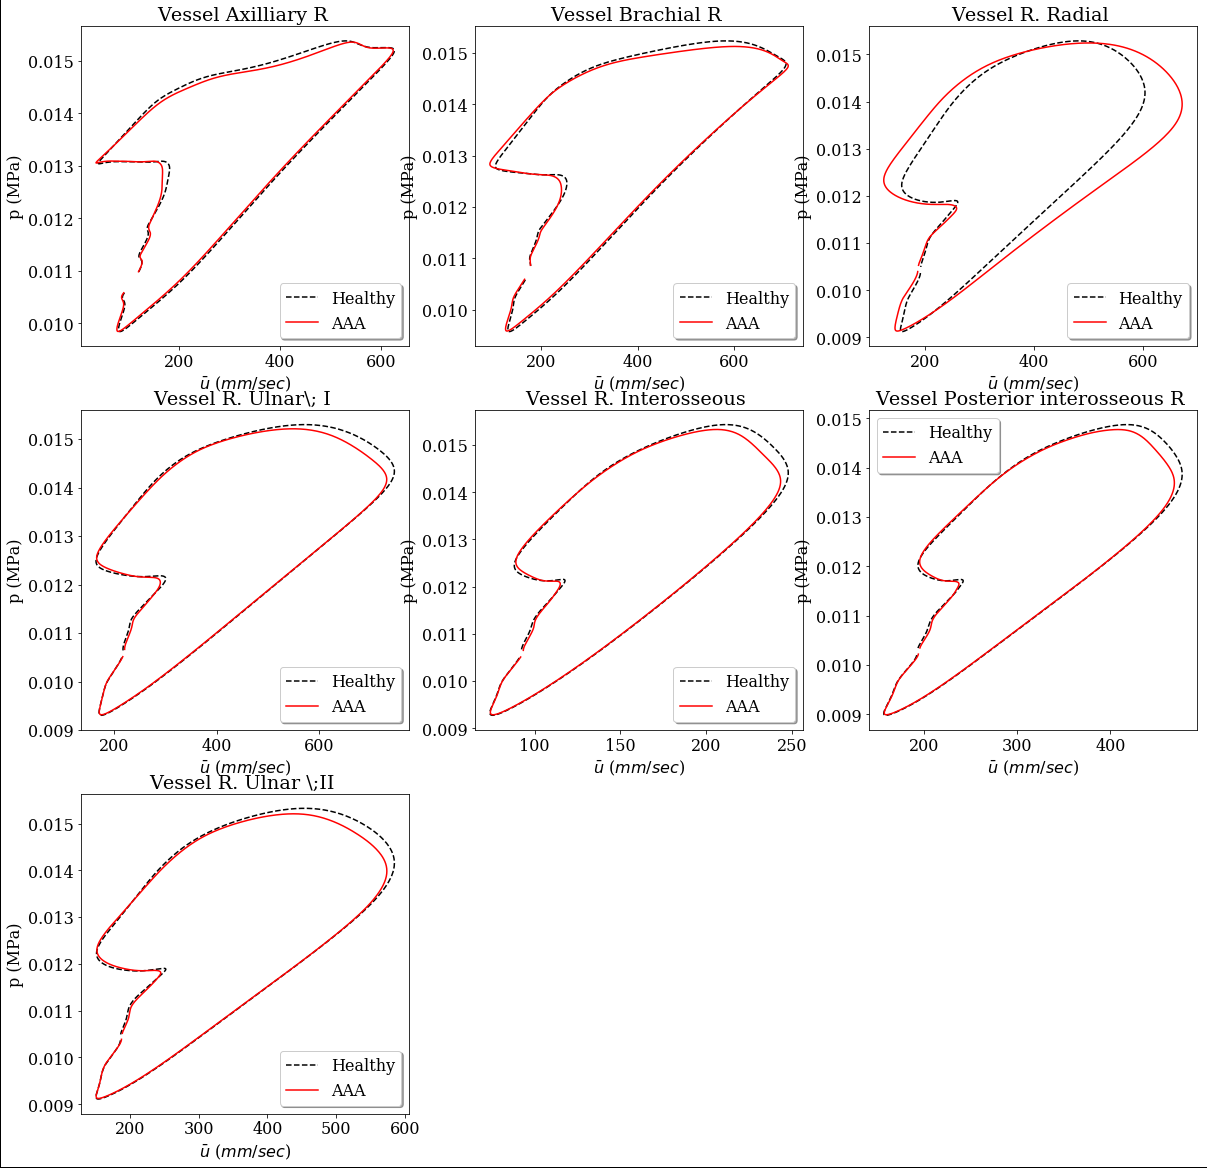

In [30]:
# pu loop at different vessels visco healthy and AAA
figpuAAA = plt.figure(figsize=(20, 20), facecolor='w', edgecolor='k',
                   linewidth= 2.0, frameon=True)

ax_puAAA = []
for i in (vessels_plot.keys()):
    ax_puAAA.append(figpuAAA.add_subplot(3, 3, i+1))
    A_b, q_b, p_b, u_b = myodbf_v.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    A_v, q_v, p_v, u_v = myodbf_vA.getUVector(vessel_no=i, cycle=4, no_points=no_points)
    T_i = myodbf.meshgrid_T
    X_i = myodbf.meshgrid_X
    p_plot = ax_puAAA[i].plot(u_b[400, :], p_b[400, :], "k--", label="Healthy")
    p_plot = ax_puAAA[i].plot(u_v[400, :], p_v[400, :], "r-", label="AAA")
    ax_puAAA[i].set_ylabel("p (MPa)")
    ax_puAAA[i].set_xlabel(r"$\bar{u}$ ($mm/sec$)")
    ax_puAAA[i].set_title("Vessel %s" % vessels_plot[i])
    ax_puAAA[i].legend(loc='best', ncol=1,
                    fancybox=True, shadow=True)
# plt.legend(loc='upper center', scatterpoints=1, ncol=1,
#            fancybox=True, bbox_to_anchor=(0.5, -0.03),
#            shadow=True)
# plt.savefig('plot3p.png', dpi=300, facecolor='w', edgecolor='w',
#             # orientation='portrait', papertype=None,
#             format='png', transparent=False, bbox_inches='tight',
#             # pad_inches=0.1,
#             frameon=None)
plt.show()

C:\Users\RagkousG\AppData\Local\conda\conda\envs\pwpykrige\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth', 'zdir', 'offset'
  s)


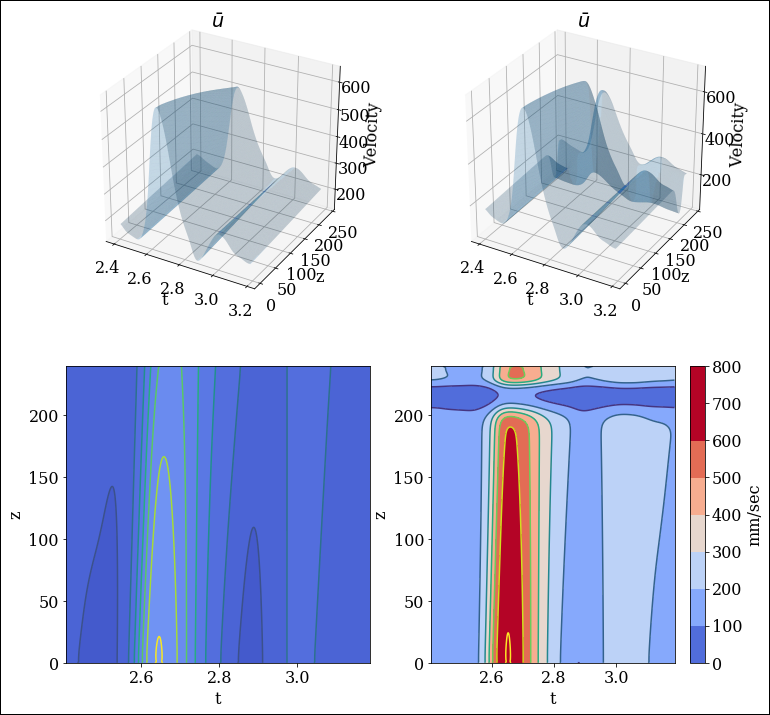

In [31]:
from matplotlib import cm

A_b, q_b, p_b, u_b = myodbf_v.getUVector(vessel_no=2, cycle=4, no_points=no_points)
A_v, q_v, p_v, u_v = myodbf_vA.getUVector(vessel_no=2, cycle=4, no_points=no_points)
T_i = myodbf.meshgrid_T
X_i = myodbf.meshgrid_X

vmin = u_v.min()
vmax = u_b.max()

#VELOCITY
fig4 = plt.figure(figsize=(12, 12), facecolor='w', edgecolor='k',
                  linewidth= 2.0, frameon=True)
ax = fig4.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(T_i, X_i, u_b, rstride=4, cstride=4, alpha=0.25,
                       linewidth=0.25, antialiased=True)
ax.view_init(30, -60)
# cset = ax.contourf(T, X, (u*qc)/(rc**2), zdir='Z', offset=5,
#                    cmap=cm.coolwarm, alpha=0.4, linewidth=0.3)
# csetl = ax.contour(T, X, (u*qc)/(rc**2), zdir='Z', offset=5, linewidth=0.3)
ax.set_xlabel('t')
ax.set_ylabel('z')
ax.set_zlabel('Velocity')
ax.set_title(r"$\bar{u}$")
# ax.set_xlim([min(t_scaled[len(t_scaled)-(len(t_scaled)/4)::])-1, max(t_scaled[len(t_scaled)-(len(t_scaled)/4)::])])
# ax.set_ylim([min(x_scaled), max(x_scaled)])
# cb4 = fig4.colorbar(cset, shrink=0.5, aspect=5)
# cb4.set_label("mm/sec")

ax2 = fig4.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(T_i, X_i, u_v, rstride=4, cstride=4, alpha=0.25,
                         linewidth=0.25, antialiased=True)
ax2.view_init(30, -60)
# cset = ax.contourf(T, X, (u*qc)/(rc**2), zdir='Z', offset=5,
#                    cmap=cm.coolwarm, alpha=0.4, linewidth=0.3)
# csetl = ax.contour(T, X, (u*qc)/(rc**2), zdir='Z', offset=5, linewidth=0.3)
ax2.set_xlabel('t')
ax2.set_ylabel('z')
ax2.set_zlabel('Velocity')
ax2.set_title(r"$\bar{u}$")

ax3 = fig4.add_subplot(2, 2, 3)
# ax2.view_init(30, -60)
cset1 = ax3.contourf(T_i, X_i, u_b, zdir='Z', offset=5,
                     cmap=cm.coolwarm, alpha=1., linewidth=0.3, vmin=0., vmax=3500.)
cset1r = ax3.contour(T_i, X_i, u_b, zdir='Z', offset=5,
                     linewidth=0.3, vmin=0., vmax=vmax)
ax3.set_xlabel('t')
ax3.set_ylabel('z')
# ax2.set_zlabel('Velocity')
# ax2.set_title(r"$\bar{u}$")

ax4 = fig4.add_subplot(2, 2, 4)
# ax2.view_init(30, -60)
cset2 = ax4.contourf(T_i, X_i, u_v, zdir='Z', offset=5,
                     cmap=cm.coolwarm, alpha=1., linewidth=0.3,
                     vmin=0., vmax=vmax)
cset2r = ax4.contour(T_i, X_i, u_v, zdir='Z', offset=5, linewidth=0.3,
                     vmin=0., vmax=vmax)
ax4.set_xlabel('t')
ax4.set_ylabel('z')

cb2 = plt.colorbar(cset2)
# cb1.set_clim(vmin=0, vmax=3000.0)
# cb1.vmin=0
# cb1.vmax=1000.
cb2.set_label("mm/sec")

plt.show()

In [33]:
# FLOW
fig1 = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k',
                  linewidth= 2.0, frameon=True)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(T-2.4, X_i, q, rstride=4, cstride=4, alpha=0.6,
                       cmap=cm.coolwarm,
                       linewidth=0.4, antialiased=True)
# ax.plot(T[0, :]-2.4, X[0, :], q[0, :], "k--", linewidth=2., label="point 0")
# ax.plot(T[1, :]-2.4, X[1, :], q[1, :], "g--", linewidth=2., label="point 1")
# ax.plot(T[2, :]-2.4, X[2, :], q[2, :], "b--", linewidth=2., label="point 2")
# ax.plot(T[3, :]-2.4, X[3, :], q[3, :], "r--", linewidth=2., label="point 3")
# ax.plot(T[10, :]-2.4, X[10, :], q[10, :], "m--", linewidth=2., label="point 4")

# ax.plot(T[25, :], X[25, :], Q[25, :]*qc, "k--", linewidth=2.)
#     cset = ax.contourf(T, X, Q, zdir='z', offset=-0.1, cmap=cm.coolwarm)
#     cset = ax.contourf(T, X, Q, zdir='x', offset=-1, cmap=cm.coolwarm)
ax.contourf(T-2.4, X, q, zdir='y', offset=500, cmap=cm.viridis)

# ax.plot_wireframe(T, X, q*qc, rstride=4, cstride=4, alpha=1.)
ax.set_xlabel('t')
ax.set_ylabel('z')
ax.set_zlabel('flow')
ax.set_title("Pulse flow wave")
# ax.set_xlim([min(t_scaled[len(t_scaled)-(len(t_scaled)/4)::]), max(t_scaled[len(t_scaled)-(len(t_scaled)/4)::])])
# ax.set_ylim([min(x_scaled), 60])
cb = fig1.colorbar(surf, shrink=0.5, aspect=5)
cb.set_label("$mm^3/sec$")
plt.legend(loc='upper center', scatterpoints=1, ncol=3,
           bbox_to_anchor=(0.5, -0.03), fancybox=True,
           shadow=True)
plt.show()

In [ ]:
#PRESSURE at point(t)
figp2D = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k',
                    linewidth= 2.0, frameon=True)
ax1 = figp2D.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
l1 = ax1.plot(T[0, :], (p[0, :])*7500.6156130264,
                        label=r"$p = p_{ext} + f(R_0, k)(1 - \sqrt{\frac{A_0}{A})}$")
l3 = ax1.plot(T[0, :], u[0,:]*0.1, "k", label=r"$\bar{u}$")
# l2 = ax2.plot(T[0, :], A[0, :]*rc**2, "g", label=r"$A = \frac{A_0}{1 - \frac{p}{f(R, k)}}$")
# ax1.scatter(T[0, 70], (((p[0, 70])*rho*qc**2)/rc**4)*7500.6156130264, s=50)
# ax1.scatter(T[0, 120], (((p[0, 120])*rho*qc**2)/rc**4)*7500.6156130264, s=50)
ax1.set_xlabel('t')
ax1.set_ylabel('p (mmHg)')
# ax2.set_ylabel("A ($mm^2$)")
# ax1.legend(loc="upper right")
# ax2.legend(loc="lower right")
# ax1.set_title(r"$p = p_{ext} + f(R_0, k)(1 - \sqrt{\frac{A_0}{A})}$")
# ax1.legend((l1,l3), (r"$p = p_{ext} + f(R_0, k)(1 - \sqrt{\frac{A_0}{A})}$", 
#                      r"$\bar{u}$"), loc='upper left', 
#            ncol=2, #bbox_to_anchor=(0., 1),
#            fancybox=True,
#            shadow=True)
plt.show()

In [ ]:
# compute diseased radius
def Gen_Hicks_bump(t_b, A, L, x, x_p, t):
    """
    Function to generate a Hicks-Henne stenosis

    Parameters
    ----------
    t_b: float
       the thickness of the walls
    A: float
     height of the stenosis peak
    L: float
     length of the tube
    x_p: float
       position of the peak stenosis
    t: float
     number to control the sharpness of the stenosis (diffusive or focal)

    Returns
    -------
    res: y value of Hicks bump
    """
    return t_b + (A - t_b)*((np.sin(np.pi*((x/L)**(-np.log(2)/np.log(x_p)))))**t)
        

In [ ]:
L = 35.
x = np.linspace(0, L, 100)
t_b = 0.43
x_p = 0.8
Stenosis = 90.
Sharpness = 10.
ID = 1.59584760745*2
IR = 0.5*ID
IR_s = IR - (IR*Stenosis)/100.
A = t_b + (IR - IR_s)
print A
y = Gen_Hicks_bump(t_b=t_b, A=A, L=L, x=x, x_p=x_p, t=Sharpness)
axis = ID + 2*t_b

y_mirror = axis - y

Diameter = y_mirror - y

# print abs((Diameter[0] - Diameter[50]) / Diameter[0])

figHicks = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k',
                      linewidth= 2.0, frameon=True)
ax = figHicks.add_subplot(1, 1, 1)
ax_twin = ax.twinx()

ax.plot(x, y, "b", label="shape %d" % (Stenosis) + "$\%$")
ax.plot(x, y_mirror, "b")
ax.fill_between(x, y, 0, facecolor='blue', alpha=0.2)
ax.fill_between(x, y_mirror, axis, facecolor='blue', alpha=0.2)
ax.fill_between(x, y, y_mirror, facecolor='red', alpha=0.2)

ax_twin.plot(x, Diameter, "r--", label="Diameter ($D_0(x)$)")


ax.set_ylim([-5, 10])
ax.set_ylabel("y(x) ($mm$)")
ax.set_xlabel("x ($mm$)")

ax_twin.set_ylabel("$D_0(x)$ ($mm$)")
# ax.legend("upper right")
ax.legend(loc='upper right', scatterpoints=1, ncol=1,
           bbox_to_anchor=(1.5, 1), fancybox=True,
           shadow=True)
ax_twin.legend(loc='upper right', scatterpoints=1, ncol=1,
               bbox_to_anchor=(1.63, 0.85), fancybox=True,
               shadow=True)
plt.title("Stenosis")
plt.show()

In [ ]:
# Aneurysm
y_1 = y + ID
y_2 = y_mirror - ID

Diameter_aneurysm = y_1 - y_2

# print abs((Diameter_aneurysm[0] - Diameter_aneurysm[50]) / Diameter_aneurysm[0])

figHicks_ = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k',
                       linewidth= 2.0, frameon=True)
ax = figHicks_.add_subplot(1, 1, 1)
ax_twin = ax.twinx()

ax.plot(x, y_1, "b", label="shape %d" % (Stenosis) + "$\%$")
ax.plot(x, y_2, "b")
ax.fill_between(x, y_1, y_1 + t_b, facecolor='blue', alpha=0.2)
ax.fill_between(x, y_2, y_2 - t_b, facecolor='blue', alpha=0.2)
ax.fill_between(x, y_1, y_2, facecolor='red', alpha=0.2)

ax_twin.plot(x, Diameter_aneurysm, "r--", label="Diameter ($D_0(x)$)")

ax.set_ylim([-5, 10])
ax.set_ylabel("y(x) ($mm$)")
ax.set_xlabel("x ($mm$)")

ax_twin.set_ylabel("$D_0(x)$ ($mm$)")

# ax.legend("upper right")
ax.legend(loc='upper right', scatterpoints=1, ncol=1,
           bbox_to_anchor=(1.5, 1), fancybox=True,
           shadow=True)
ax_twin.legend(loc='upper right', scatterpoints=1, ncol=1,
               bbox_to_anchor=(1.63, 0.85), fancybox=True,
               shadow=True)
plt.title("Aneurysm")
plt.show()

In [ ]:
# class inheritted by the ScaledVessel to overwrite the computation of R0 
class StenosisVessel(VesselScaled):
    def __init__(self, x_p, t, d_disease, type_disease,
                 *args, **kwargs):
        super(StenosisVessel, self).__init__(*args, **kwargs)
        self._x_p = x_p
        self._sharpness = t
        self._d_disease = d_disease
        self._type_disease = type_disease

    def calculate_R0(self):
        y = self.Gen_Hicks_bump(self._x)
        axis = self.r_prox*2 + 2*self.w_th
        if self._type_disease == "stenosis":
            print "yes"
            y_mirror = axis - y
            Diameter = y_mirror - y
        elif self._type_disease == "aneurysm":
            y_1 = y + 2*self.r_prox
            y_2 = (axis - y) - 2*self.r_prox
            Diameter = y_1 - y_2
        print("Diameter", Diameter)
        return Diameter / 2.

    def interpolate_R0(self, value):
        y = self.Gen_Hicks_bump(self.x + self._dx*value)
        axis = self.r_prox*2 + 2*self.w_th
        if self._type_disease == "stenosis":
            y_mirror = axis - y
            Diameter = y_mirror - y
        elif self._type_disease == "aneurysm":
            y_1 = y + 2*self.r_prox
            y_2 = (axis - y) - 2*self.r_prox
            Diameter = y_1 - y_2

        return Diameter / 2.

    def Gen_Hicks_bump(self, x):
        A = (self.w_th + (self.r_prox - (self.r_prox -
             (self.r_prox*self._d_disease)/100.)))
        return (self.w_th + (A - self.w_th) *
                ((np.sin(np.pi*((x/self._L)**(-np.log(2) /
                np.log(self._x_p)))))**self._sharpness))